# Realistic Multiuser MIMO OFDM Simulations
In this notebook, you will learn how to setup realistic simulations
of multiuser MIMO uplink transmissions. Multiple user terminals (UTs)
are randomly distributed in a cell sector and communicate with a multi-antenna
base station.


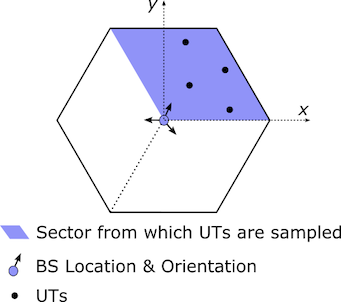

The block-diagramm of the system model looks as follows:


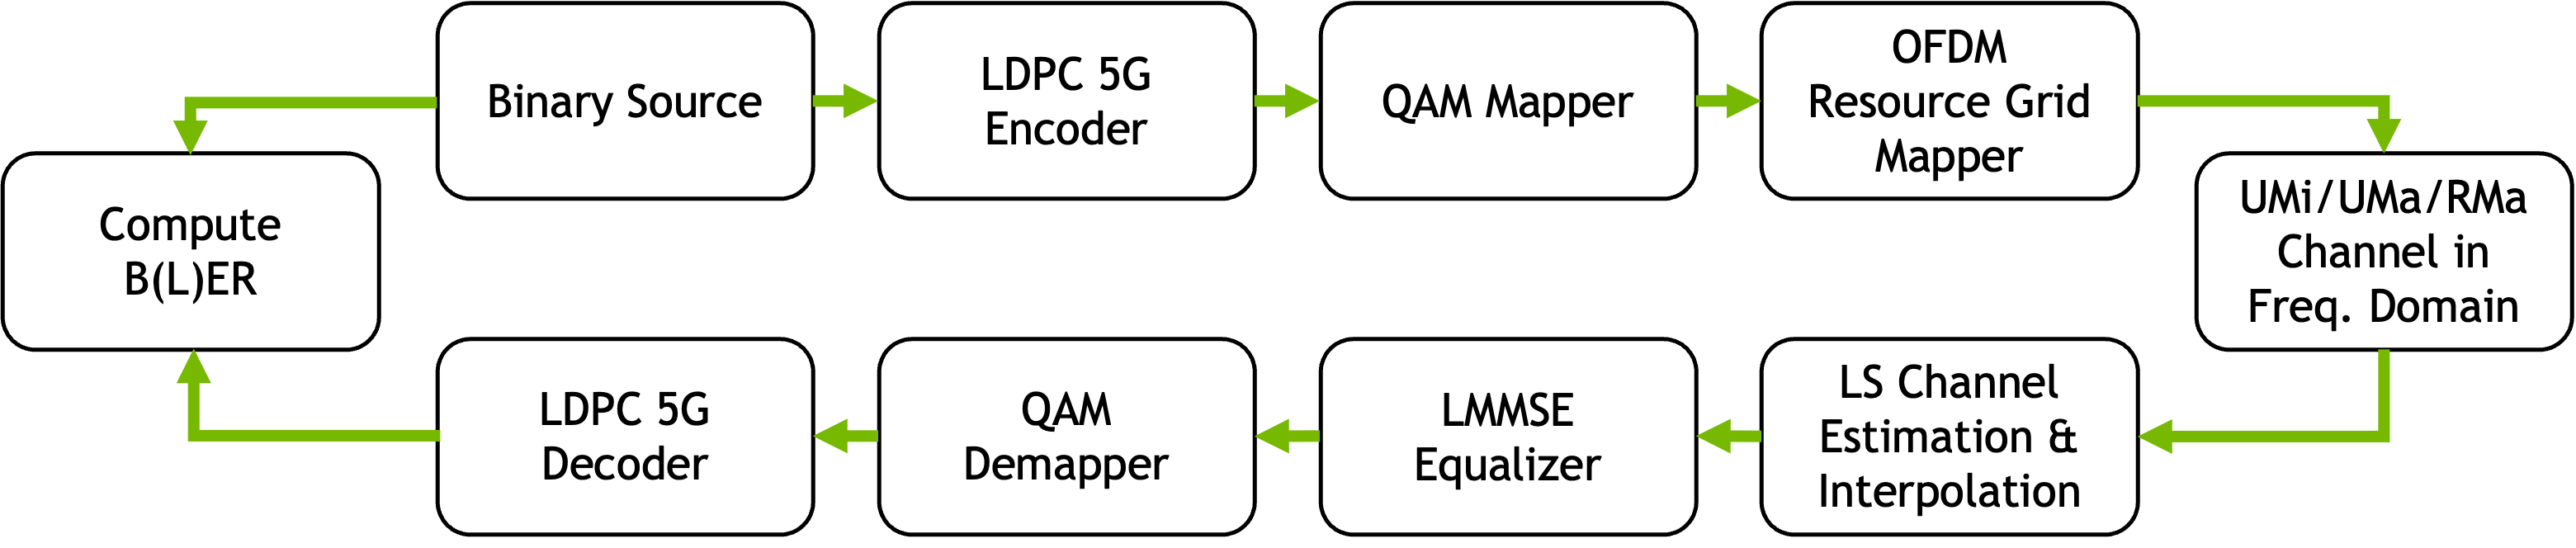

It includes the following components:

- 5G LDPC FEC
- QAM modulation
- OFDM resource grid with configurable pilot pattern
- Multiple single-antenna transmitters and a multi-antenna receiver
- 3GPP 38.901 UMi, UMa, and RMa channel models and antenna patterns
- LS Channel estimation with nearest-neighbor interpolation as well as perfect CSI
- LMMSE MIMO equalization

You will learn how to setup the topologies required to simulate such scenarios and investigate

- the performance over different models, and
- the impact of imperfect CSI.

We will first walk through the configuration of all components of the system model, before simulating
some simple uplink transmissions in the frequency domain. We will then simulate CDFs of the channel condition number
and look into frequency-selectivity of the different channel models to understand the reasons for the observed performance differences.

It is recommended that you familiarize yourself with the [API documentation](https://nvlabs.github.io/sionna/api/channel.html) of the `Channel` module
and, in particular, the 3GPP 38,901 models that require a substantial amount of configuration.  The last set of simulations in this notebook take some time, especially when you have no GPU available. For this reason, we provide the simulation
results directly in the cells generating the figures. Simply uncomment the corresponding lines to show this results.

## Table of Contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [System Setup](#System-Setup)
* [Uplink Transmissions in the Frequency Domain](#Uplink-Transmissions-in-the-Frequency-Domain)
    * [Compare Estimated and Actual Frequency Responses](#Compare-Estimated-and-Actual-Frequency-Responses)
    * [Understand the Difference Between the Channel Models](#Understand-the-Difference-Between-the-Channel-Models)
    * [Setup a Keras Model for BER simulations](#Setup-a-Keras-Model-for-BER-simulations)

## GPU Configuration and Imports

In [23]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
import sys
sys.path.append('../')
import sionna

# try:
#     import sionna
# except ImportError as e:
#     # Install Sionna if package is not already installed
#     import os
#     os.system("pip install sionna")
#     import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Set random seed for reproducibility
sionna.config.seed = 42

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle

from sionna.mimo import StreamManagement

from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer
from sionna.ofdm import OFDMModulator, OFDMDemodulator, ZFPrecoder, RemoveNulledSubcarriers

from sionna.channel.tr38901 import Antenna, AntennaArray, CDL, UMi, UMa, RMa
from sionna.channel import gen_single_sector_topology as gen_topology
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel
from sionna.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel

from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

from sionna.mapping import Mapper, Demapper

from sionna.utils import BinarySource, ebnodb2no, sim_ber, QAMSource
from sionna.utils.metrics import compute_ber

## System Setup

We will now configure all components of the system model step-by-step.

In [25]:
scenario = "umi"
carrier_frequency = 3.5e9
direction = "uplink"
num_ut = 4
batch_size = 4

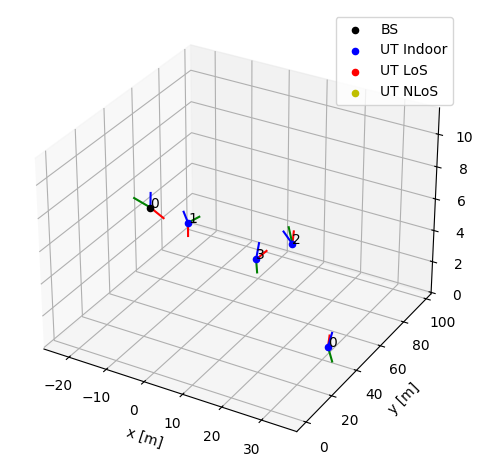

In [26]:
# Define the UT antenna array
ut_array = Antenna(polarization="single",
                   polarization_type="V",
                   antenna_pattern="omni",
                   carrier_frequency=carrier_frequency)

# Define the BS antenna array
bs_array = AntennaArray(num_rows=1,
                        num_cols=4,
                        polarization="dual",
                        polarization_type="VH",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)

# Create channel model
channel_model = UMi(carrier_frequency=carrier_frequency,
                    o2i_model="low",
                    ut_array=ut_array,
                    bs_array=bs_array,
                    direction=direction,
                    enable_pathloss=False,
                    enable_shadow_fading=False)

# Generate the topology
topology = gen_topology(batch_size, num_ut, scenario)

# Set the topology
channel_model.set_topology(*topology)

# Visualize the topology
channel_model.show_topology()

In [27]:
# The number of transmitted streams is equal to the number of UT antennas
num_streams_per_tx = 1

# Create an RX-TX association matrix
# rx_tx_association[i,j]=1 means that receiver i gets at least one stream
# from transmitter j. Depending on the transmission direction (uplink or downlink),
# the role of UT and BS can change. However, as we have only a single
# transmitter and receiver, this does not matter:
rx_tx_association = np.zeros([1, num_ut])
rx_tx_association[0, :] = 1

# Instantiate a StreamManagement object
# This determines which data streams are determined for which receiver.
# In this simple setup, this is fairly simple. However, it can get complicated
# for simulations with many transmitters and receivers.
sm = StreamManagement(rx_tx_association, num_streams_per_tx)

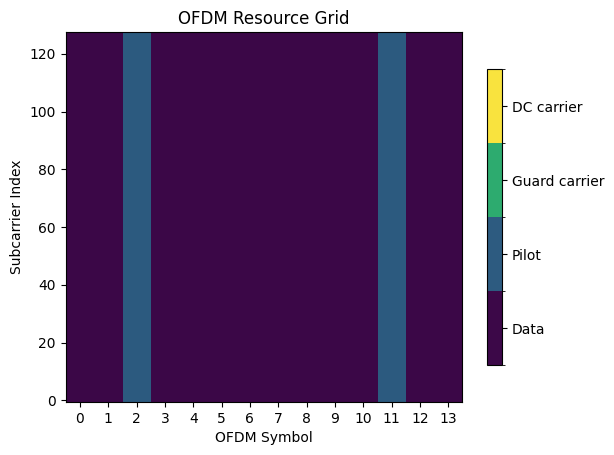

In [28]:
rg = ResourceGrid(num_ofdm_symbols=14,
                  fft_size=128,
                  subcarrier_spacing=30e3,
                  num_tx=num_ut,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=20,
                  pilot_pattern="kronecker",
                  pilot_ofdm_symbol_indices=[2,11])
rg.show();

In [29]:
num_bits_per_symbol = 2 # QPSK modulation
coderate = 0.5 # The code rate
n = int(rg.num_data_symbols*num_bits_per_symbol) # Number of coded bits
k = int(n*coderate) # Number of information bits

# The binary source will create batches of information bits
binary_source = BinarySource()
qam_source = QAMSource(num_bits_per_symbol)

# The encoder maps information bits to coded bits
encoder = LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = Mapper("qam", num_bits_per_symbol)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = ResourceGridMapper(rg)

# This function removes nulled subcarriers from any tensor having the shape of a resource grid
remove_nulled_scs = RemoveNulledSubcarriers(rg)

# The LS channel estimator will provide channel estimates and error variances
ls_est = LSChannelEstimator(rg, interpolation_type="nn")

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
lmmse_equ = LMMSEEqualizer(rg, sm)

# The demapper produces LLR for all coded bits
demapper = Demapper("app", "qam", num_bits_per_symbol)

# The decoder provides hard-decisions on the information bits
decoder = LDPC5GDecoder(encoder, hard_out=True)

# OFDM CHannel
ofdm_channel = OFDMChannel(channel_model, rg, add_awgn=True, normalize_channel=False, return_channel=True)
channel_freq = ApplyOFDMChannel(add_awgn=True)
frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)

## Uplink Transmissions in the Frequency Domain

We now simulate a batch of uplink transmissions. We keep references to the estimated and actual channel frequency responses.

In [30]:
ebno_db = 10
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)
b = binary_source([batch_size, num_ut, rg.num_streams_per_tx, encoder.k])
c = encoder(b)
x = mapper(c)
x_rg = rg_mapper(x)

a, tau = channel_model(num_time_samples=rg.num_ofdm_symbols, sampling_frequency=1/rg.ofdm_symbol_duration)
h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=True)

y = channel_freq([x_rg, h_freq, no])
h_hat, err_var = ls_est ([y, no])
x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)
print("BER: {}".format(compute_ber(b, b_hat).numpy()))

BER: 0.0


### Compare Estimated and Actual Frequency Responses
We can now compare the estimated frequency responses and ground truth:

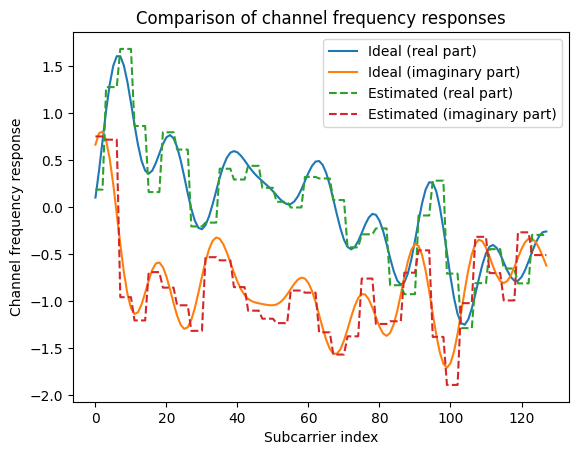

In [31]:
# In the example above, we assumed perfect CSI, i.e.,
# h_hat correpsond to the exact ideal channel frequency response.
h_perf = remove_nulled_scs(h_freq)[0,0,0,0,0,0]

# We now compute the LS channel estimate from the pilots.
h_est = h_hat[0,0,0,0,0,0]

plt.figure()
plt.plot(np.real(h_perf))
plt.plot(np.imag(h_perf))
plt.plot(np.real(h_est), "--")
plt.plot(np.imag(h_est), "--")
plt.xlabel("Subcarrier index")
plt.ylabel("Channel frequency response")
plt.legend(["Ideal (real part)", "Ideal (imaginary part)", "Estimated (real part)", "Estimated (imaginary part)"]);
plt.title("Comparison of channel frequency responses");

### Understand the Difference Between the Channel Models
Before we proceed with more advanced simulations, it is important to understand the differences
between the UMi, UMa, and RMa models. In the following code snippet, we compute the empirical cummulative
distribution function (CDF) of the condition number of the channel frequency response matrix
between all receiver and transmit antennas.

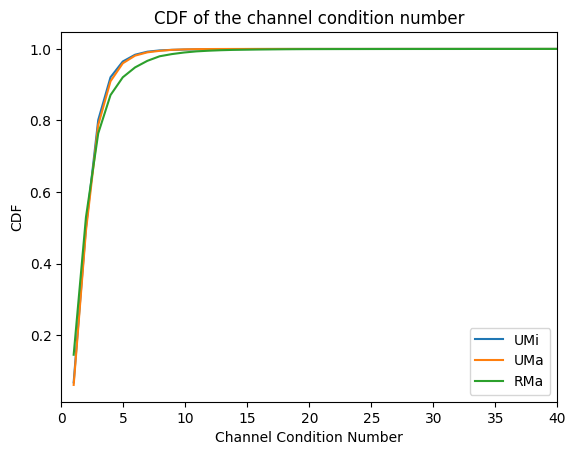

In [32]:
def cond_hist(scenario):
    """Generates a histogram of the channel condition numbers"""
    
    # Setup a CIR generator
    if scenario == "umi":
        channel_model = UMi(carrier_frequency=carrier_frequency,
                                      o2i_model="low",
                                      ut_array=ut_array,
                                      bs_array=bs_array,
                                      direction="uplink",
                                      enable_pathloss=False,
                                      enable_shadow_fading=False)
    elif scenario == "uma":
        channel_model = UMa(carrier_frequency=carrier_frequency,
                                      o2i_model="low",
                                      ut_array=ut_array,
                                      bs_array=bs_array,
                                      direction="uplink",
                                      enable_pathloss=False,
                                      enable_shadow_fading=False)
    elif scenario == "rma":
        channel_model = RMa(carrier_frequency=carrier_frequency,
                                      ut_array=ut_array,
                                      bs_array=bs_array,
                                      direction="uplink",
                                      enable_pathloss=False,
                                      enable_shadow_fading=False)
    
    topology = gen_topology(1024, num_ut, scenario)

    # Set the topology
    channel_model.set_topology(*topology)
    
    # Generate random CIR realizations
    # As we nned only a single sample in time, the sampling_frequency
    # does not matter.
    cir = channel_model(1, 1)
    
    # Compute the frequency response
    h = cir_to_ofdm_channel(frequencies, *cir, normalize=True)
    
    h = tf.squeeze(h)
    h = tf.transpose(h, [0,3,1,2])
    
    # Compute condition number
    c = np.reshape(np.linalg.cond(h), [-1])
    
    # Compute normalized histogram
    hist, bins = np.histogram(c, 100, (1, 100))
    hist = hist/np.sum(hist)
    return bins[:-1], hist

plt.figure()
for cdl_model in ["umi", "uma", "rma"]:
    bins, hist = cond_hist(cdl_model)
    plt.plot(bins, np.cumsum(hist))
plt.xlim([0,40])
plt.legend(["UMi", "UMa", "RMa"]);
plt.xlabel("Channel Condition Number")
plt.ylabel("CDF")
plt.title("CDF of the channel condition number");

From the figure above, you can observe that the UMi and UMa models
are better conditioned than the RMa model. This makes 
them more suitable for MIMO transmissions as we will observe in the next
section.

It is also interesting to look at the channel frequency responses of these different models, as done in the next cell:

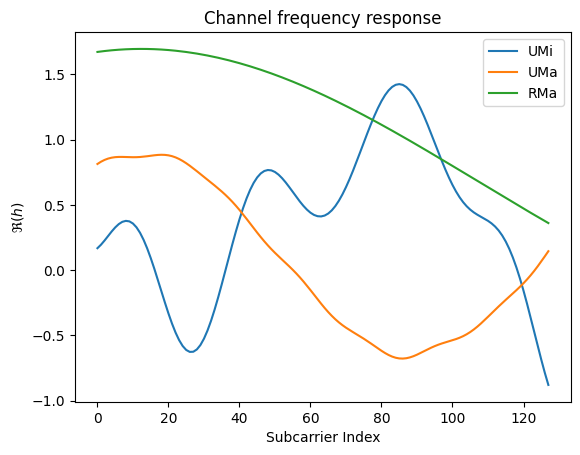

In [33]:
def freq_response(scenario):
    """Generates an example frequency response"""
    
    # Setup a CIR generator
    if scenario == "umi":
        channel_model = UMi(carrier_frequency=carrier_frequency,
                                      o2i_model="low",
                                      ut_array=ut_array,
                                      bs_array=bs_array,
                                      direction="uplink",
                                      enable_pathloss=False,
                                      enable_shadow_fading=False)
    elif scenario == "uma":
        channel_model = UMa(carrier_frequency=carrier_frequency,
                                      o2i_model="low",
                                      ut_array=ut_array,
                                      bs_array=bs_array,
                                      direction="uplink",
                                      enable_pathloss=False,
                                      enable_shadow_fading=False)
    elif scenario == "rma":
        channel_model = RMa(carrier_frequency=carrier_frequency,
                                      ut_array=ut_array,
                                      bs_array=bs_array,
                                      direction="uplink",
                                      enable_pathloss=False,
                                      enable_shadow_fading=False)
    
    topology = gen_topology(1, num_ut, scenario)

    # Set the topology
    channel_model.set_topology(*topology)
    
    # Generate random CIR realizations
    # As we nned only a single sample in time, the sampling_frequency
    # does not matter.
    cir = channel_model(1, 1)
    
    # Compute the frequency response
    h = cir_to_ofdm_channel(frequencies, *cir, normalize=True)
    h = tf.squeeze(h)

    return h[0,0]

plt.figure()
for cdl_model in ["umi", "uma", "rma"]:
    h = freq_response(cdl_model)
    plt.plot(np.real(h))
plt.legend(["UMi", "UMa", "RMa"]);
plt.xlabel("Subcarrier Index")
plt.ylabel(r"$\Re(h)$")
plt.title("Channel frequency response");

The RMa model has significantly less frequency selectivity than the other models which makes channel estimation easier.

### Setup a Keras Model for BER simulations

In [34]:
class Model(tf.keras.Model):
    """Simulate OFDM MIMO transmissions over a 3GPP 38.901 model.
    """
    def __init__(self, scenario, perfect_csi):
        super().__init__()
        self._scenario = scenario
        self._perfect_csi = perfect_csi
        
        # Internally set parameters
        self._carrier_frequency = 3.5e9
        self._fft_size = 128
        self._subcarrier_spacing = 30e3
        self._num_ofdm_symbols = 14
        self._cyclic_prefix_length = 20
        self._pilot_ofdm_symbol_indices = [2, 11]      
        self._num_bs_ant = 8
        self._num_ut = 4
        self._num_ut_ant = 1
        self._num_bits_per_symbol = 2 
        self._coderate = 0.5
    
        # Create an RX-TX association matrix
        # rx_tx_association[i,j]=1 means that receiver i gets at least one stream
        # from transmitter j. Depending on the transmission direction (uplink or downlink),
        # the role of UT and BS can change. 
        bs_ut_association = np.zeros([1, self._num_ut])
        bs_ut_association[0, :] = 1
        self._rx_tx_association = bs_ut_association
        self._num_tx = self._num_ut
        self._num_streams_per_tx = self._num_ut_ant

            
        # Setup an OFDM Resource Grid
        self._rg = ResourceGrid(num_ofdm_symbols=self._num_ofdm_symbols,
                                fft_size=self._fft_size,
                                subcarrier_spacing=self._subcarrier_spacing,
                                num_tx=self._num_tx,
                                num_streams_per_tx=self._num_streams_per_tx,
                                cyclic_prefix_length=self._cyclic_prefix_length,
                                pilot_pattern="kronecker",
                                pilot_ofdm_symbol_indices=self._pilot_ofdm_symbol_indices)
             
        # Setup StreamManagement
        self._sm = StreamManagement(self._rx_tx_association, self._num_streams_per_tx)
               
        # Configure antenna arrays
        self._ut_array = AntennaArray(
                                 num_rows=1,
                                 num_cols=1,
                                 polarization="single",
                                 polarization_type="V",
                                 antenna_pattern="omni",
                                 carrier_frequency=self._carrier_frequency)
        
        self._bs_array = AntennaArray(num_rows=1,
                                      num_cols=int(self._num_bs_ant/2),
                                      polarization="dual",
                                      polarization_type="cross",
                                      antenna_pattern="38.901",
                                      carrier_frequency=self._carrier_frequency)
        
        # Configure the channel model
        if self._scenario == "umi":
            self._channel_model = UMi(carrier_frequency=self._carrier_frequency,
                                      o2i_model="low",
                                      ut_array=self._ut_array,
                                      bs_array=self._bs_array,
                                      direction="uplink",
                                      enable_pathloss=False,
                                      enable_shadow_fading=False)
        elif self._scenario == "uma":
            self._channel_model = UMa(carrier_frequency=self._carrier_frequency,
                                      o2i_model="low",
                                      ut_array=self._ut_array,
                                      bs_array=self._bs_array,
                                      direction="uplink",
                                      enable_pathloss=False,
                                      enable_shadow_fading=False)
        elif self._scenario == "rma":
            self._channel_model = RMa(carrier_frequency=self._carrier_frequency,
                                      ut_array=self._ut_array,
                                      bs_array=self._bs_array,
                                      direction="uplink",
                                      enable_pathloss=False,
                                      enable_shadow_fading=False)
            
        # Instantiate other building blocks
        self._binary_source = BinarySource()
        self._qam_source = QAMSource(self._num_bits_per_symbol)
        
        self._n = int(self._rg.num_data_symbols*self._num_bits_per_symbol) # Number of coded bits
        self._k = int(self._n*self._coderate)                              # Number of information bits
        self._encoder = LDPC5GEncoder(self._k, self._n)
        self._decoder = LDPC5GDecoder(self._encoder)
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(self._rg)
        
        self._ofdm_channel = OFDMChannel(self._channel_model, self._rg, add_awgn=True,
                                         normalize_channel=True, return_channel=True)
       
        self._remove_nulled_subcarriers = RemoveNulledSubcarriers(self._rg)
        self._ls_est = LSChannelEstimator(self._rg, interpolation_type="nn")
        self._lmmse_equ = LMMSEEqualizer(self._rg, self._sm)
        self._demapper = Demapper("app", "qam", self._num_bits_per_symbol)

    def new_topology(self, batch_size):
        """Set new topology"""
        topology = gen_topology(batch_size,
                                self._num_ut,
                                self._scenario,
                                min_ut_velocity=0.0,
                                max_ut_velocity=0.0)
        
        self._channel_model.set_topology(*topology)
        
    @tf.function # Run in graph mode. See the following guide: https://www.tensorflow.org/guide/function
    def call(self, batch_size, ebno_db):        
        self.new_topology(batch_size) 
        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._coderate, self._rg)
        b = self._binary_source([batch_size, self._num_tx, self._num_streams_per_tx, self._k])
        c = self._encoder(b)
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)   
        y, h = self._ofdm_channel([x_rg, no])
        if self._perfect_csi:
            h_hat = self._remove_nulled_subcarriers(h)
            err_var = 0.0        
        else:
            h_hat, err_var = self._ls_est ([y, no])
        x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no])
        llr = self._demapper([x_hat, no_eff])
        b_hat = self._decoder(llr)                       
        return b, b_hat 

If you do not want to run the simulations (which can take quite some time) yourself, you can skip the next cell and simply look at the results in the next cell.

In [ ]:
SIMS = {
    "ebno_db" : list(np.arange(-5, 17, 2.0)),
    "scenario" : ["umi", "uma", "rma"],
    "perfect_csi" : [True, False],
    "ber" : [],
    "bler" : [],
    "duration" : None
}

start = time.time()

for scenario in SIMS["scenario"]:
    for perfect_csi in SIMS["perfect_csi"]:
    
        model = Model(scenario=scenario,
                      perfect_csi=perfect_csi)
    
        ber, bler = sim_ber(model,
                            SIMS["ebno_db"],
                            batch_size=128,
                            max_mc_iter=1000,
                            num_target_block_errors=1000,
                            target_bler=1e-3)
    
        SIMS["ber"].append(list(ber.numpy()))
        SIMS["bler"].append(list(bler.numpy()))
    
SIMS["duration"] = time.time() -  start

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.0594e-02 | 3.1390e-01 |      168419 |     5505024 |         1125 |        3584 |        61.4 |reached target block errors
     -3.0 | 2.2479e-03 | 2.5040e-02 |      137887 |    61341696 |         1000 |       39936 |       467.5 |reached target block errors
     -1.0 | 2.4660e-04 | 2.5938e-03 |      146033 |   592183296 |         1000 |      385536 |      4323.5 |reached target block errors


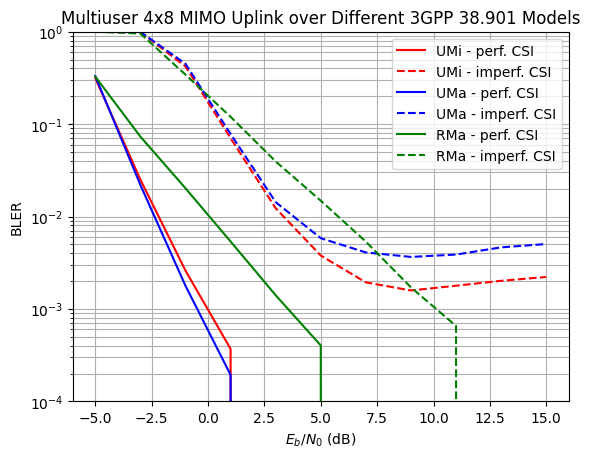

In [14]:
plt.figure()
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")

i=0
legend = []
for scenario in SIMS["scenario"]:
    for perfect_csi in SIMS["perfect_csi"]:
        if scenario=="umi":
            r = "r"
            t = "UMi"
        elif scenario=="uma":
            r = "b"
            t = "UMa"
        else:
            r = "g"
            t = "RMa"
        if perfect_csi:
            r += "-"
        else:
            r += "--"
                
        plt.semilogy(SIMS["ebno_db"], SIMS["bler"][i], r);
        s = "{} - {} CSI".format(t,"perf." if perfect_csi else "imperf.")
        
        legend.append(s)
        i += 1
plt.legend(legend)
plt.ylim([1e-4, 1])
plt.title("Multiuser 4x8 MIMO Uplink over Different 3GPP 38.901 Models");

Due to the worse channel conditioning, the RMa model achieves the worst performance with perfect CSI. However, as a result of the smaller frequency selectivity, imperfect channel estimation only leads to an almost constant 6dB performace loss. For the UMI and UMa models, the used channel estimator with nearest-neighbor interpolation is not accurate enough so that the BER curves saturate at high SNR. This could, for example, be circumvented with another interpolation method (e.g., [linear interpolation with time averaging](https://nvlabs.github.io/sionna/api/ofdm.html#linearinterpolator)) or a different pilot pattern.